# PREAMBLE

In [2]:
import sys
from config import *
import pickle
import mne
from hypyp import utils
from hypyp import analyses
import numpy as np
from numpy import pi, arange, random, max
from scipy.io import loadmat
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

# https://jitcde-common.readthedocs.io/en/stable/#installation
import os
os.environ["CC"] = "gcc"
# https://jitcdde.readthedocs.io/en/stable/
from jitcdde import jitcdde_input, y, t, input
from symengine import sin
from chspy import CubicHermiteSpline

# 1. ORDER PARAMETER VS CINTRA (FIRST LOOK)

[[0.00000000e+00 1.47870425e-04 5.65719744e-04 ... 7.00210112e-05
  2.80926577e-04 1.23042516e-04]
 [1.47870425e-04 0.00000000e+00 1.46770805e-04 ... 2.37906869e-05
  2.45674567e-05 1.42365140e-04]
 [5.65719744e-04 1.46770805e-04 0.00000000e+00 ... 2.65199967e-05
  0.00000000e+00 1.07263643e-04]
 ...
 [7.00210112e-05 2.37906869e-05 2.65199967e-05 ... 0.00000000e+00
  1.78504311e-05 5.80307554e-04]
 [2.80926577e-04 2.45674567e-05 0.00000000e+00 ... 1.78504311e-05
  0.00000000e+00 4.49503093e-05]
 [1.23042516e-04 1.42365140e-04 1.07263643e-04 ... 5.80307554e-04
  4.49503093e-05 0.00000000e+00]]


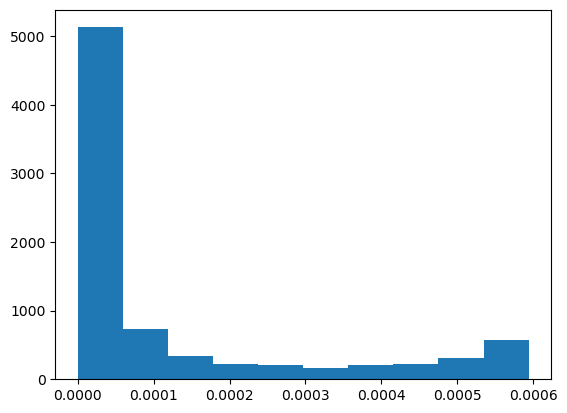

Mean: 0.0001234567901234568


In [8]:
dti = loadmat("connectomes.mat")['cuban'] # self-connections (diagonals) are already 0

## NORMALISATION
# dti = (dti - np.min(dti)) / (np.max(dti) - np.min(dti))
# dti = dti/np.sum(dti)

plt.hist(dti.flatten())
plt.show()
print("Mean:",np.mean(dti))

nsfreq = 100.0
freq_mean = 4.0 # theta oscillations 

# Following options [0, 0.5, 1]
freq_std = 1.0
phase_noise = 0.5
amp_noise = 0.0
sensor_noise = 0.0

n = 90

100%|██████████| 100/100 [00:00<00:00, 1861.86it/s]


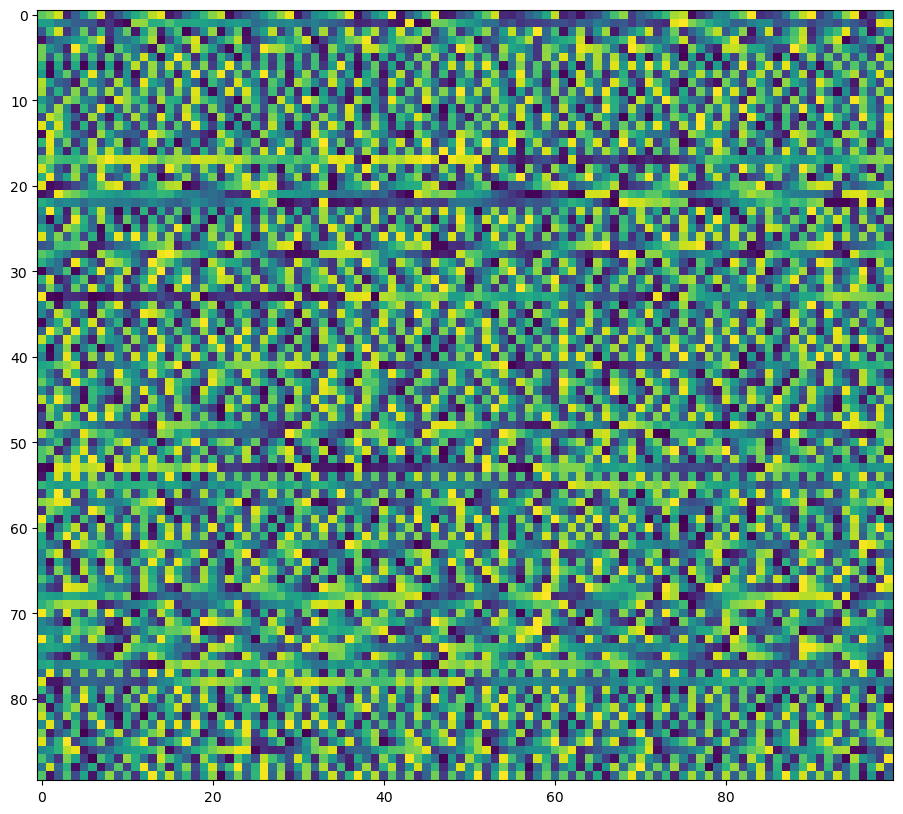

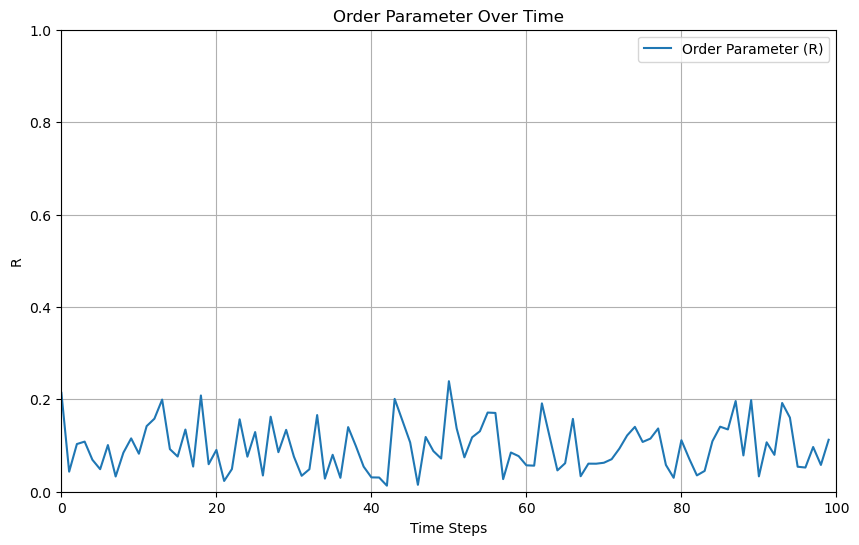

100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


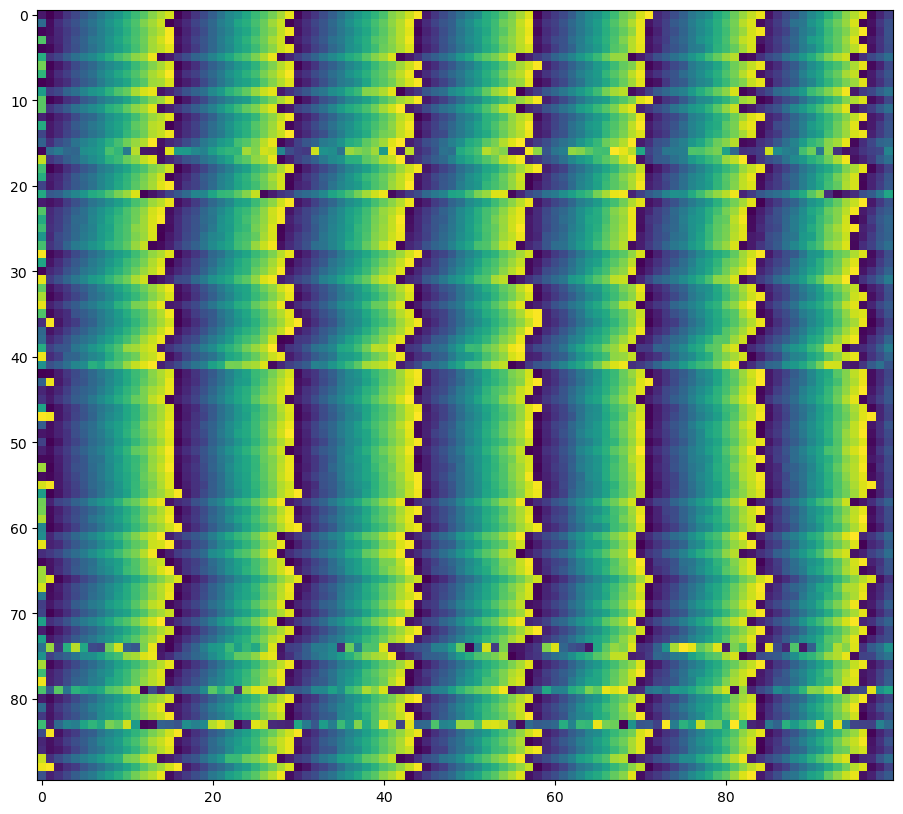

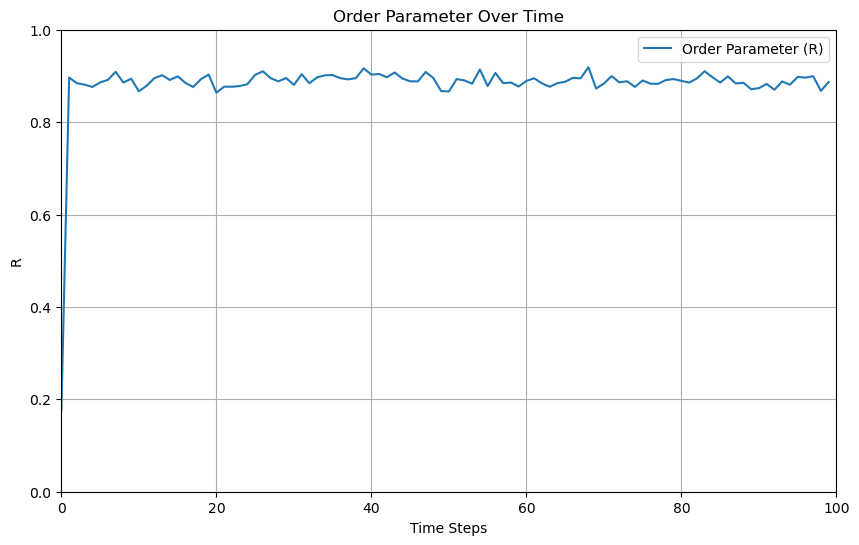

100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


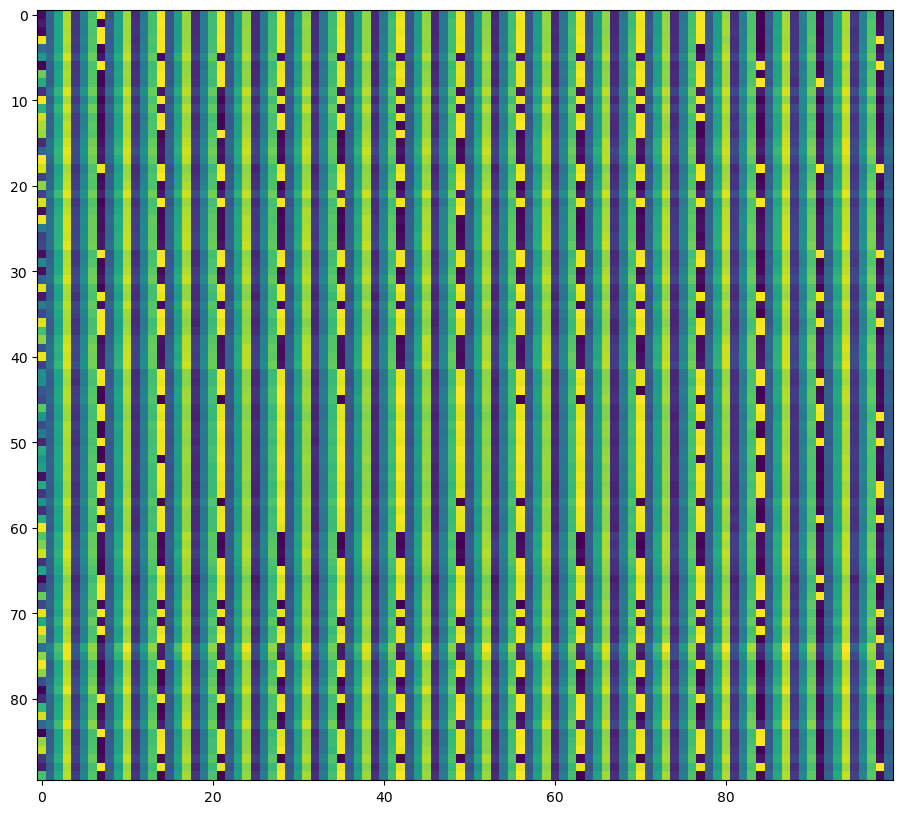

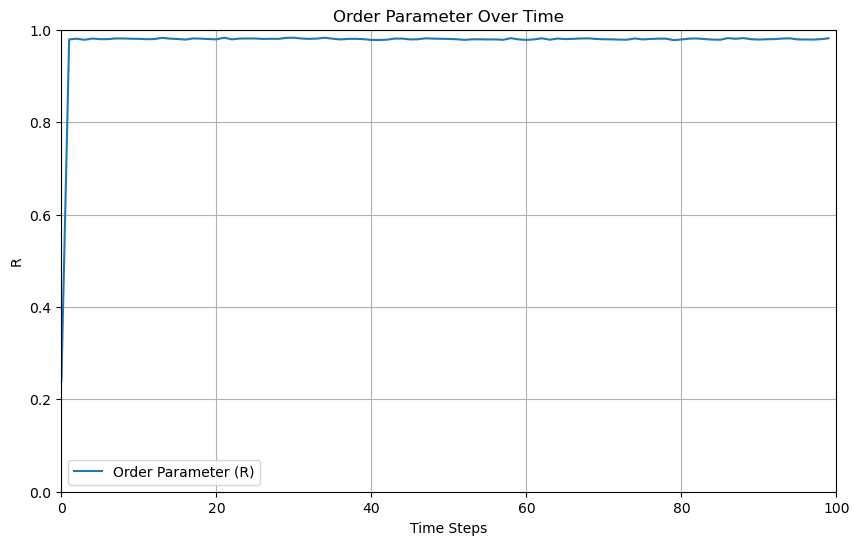

100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


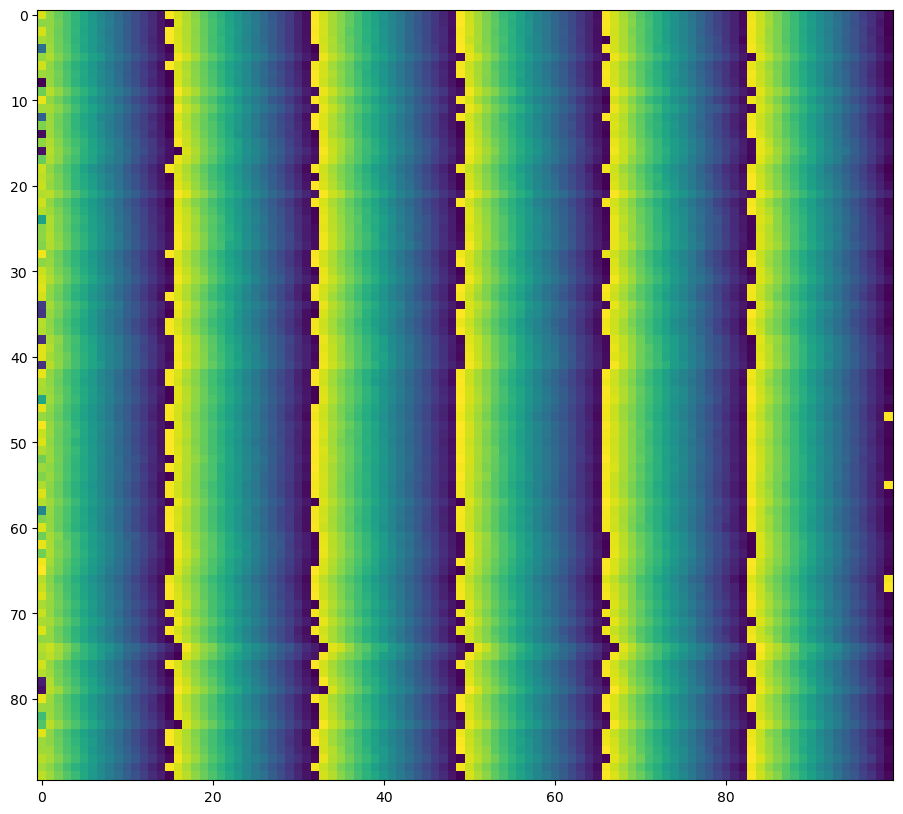

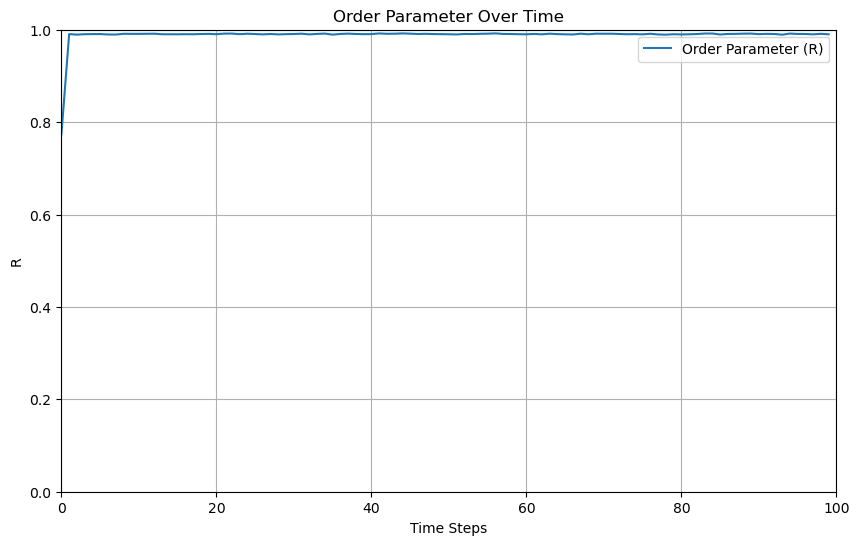

100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


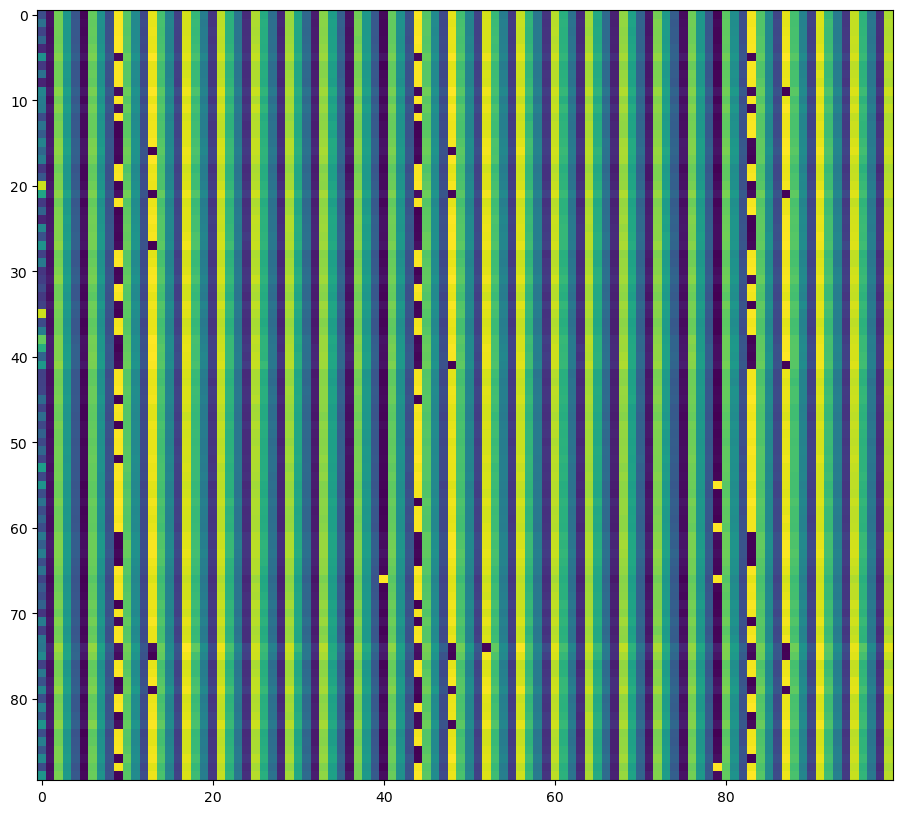

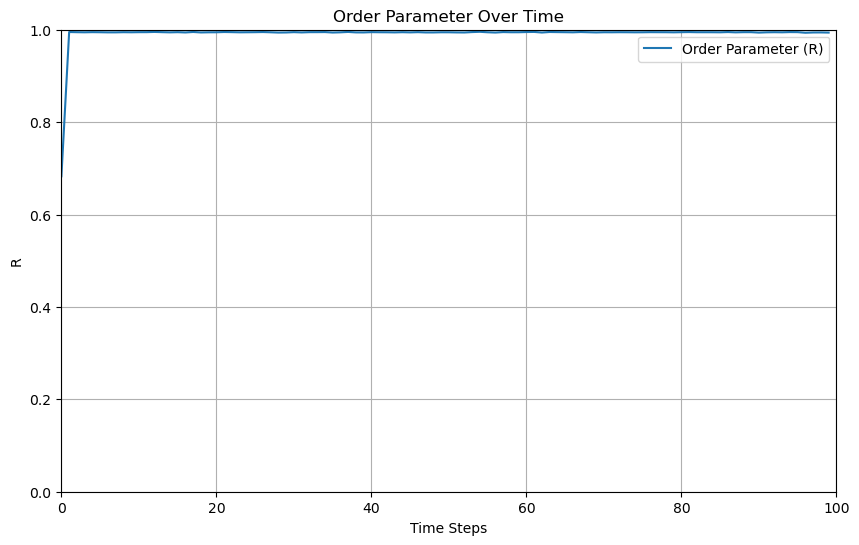

Simulating: 100%|██████████| 5/5 [05:10<00:00, 62.01s/it]


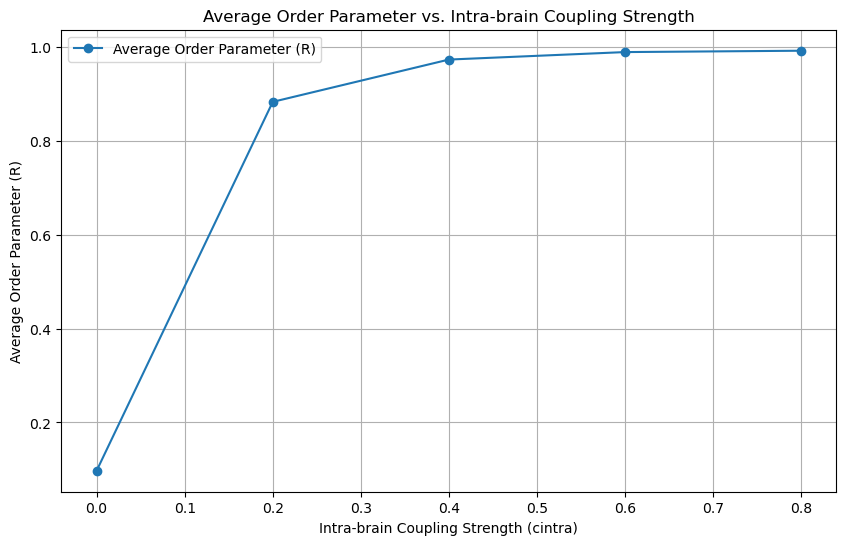

In [ ]:

cintra_values = np.arange(0.0, 1.0, 0.2)
R_avg_values = []  # To collect average R values for each cintra

w_d = np.array(loadmat("distance.mat")['distance'])
pulsations = (np.random.randn(1, n) * freq_std_factor * freq_std + freq_mean) * (2 * pi) / (sfreq)
times = arange(0, (n_times + 2) * sfreq, 1)

velocity = 1.65 # 6 or 1.65 (Dumas e2012)?


cintra = 0

def kuramotos():
        for i in range(n):
            yield ω[i] + 0.1 * (sum(
                A[j, i] * sin(y(j, t - τ[i, j]) - y(i))
                for j in range(n)
            ) + phase_noise * input(i))

for cintra in tqdm(cintra_values, desc='Simulating'):
    
    # Intra-brain coupling
    w_c = np.array(dti * cintra)

    ω = pulsations.flatten()
    A = w_c
    τ = sfreq * w_d / velocity

    input_data = np.random.normal(size=(len(times), n))
    input_spline = CubicHermiteSpline.from_data(times, input_data)


    DDE = jitcdde_input(f_sym=kuramotos,
                            n=n,
                            input=input_spline,
                            verbose=True)

    DDE.compile_C(simplify=False, do_cse=False, chunk_size=1)
    DDE.set_integration_parameters(rtol=0.0001, atol=0.0000001)
    DDE.constant_past(random.uniform(0, 2 * pi, n), time=0.0)
    DDE.integrate_blindly(max(τ), 1)

    output = []
    for time in tqdm(DDE.t + arange(0, 10000, 100)):    ## THIS WILL BE CHANGED IN THE NEXT SECTION!
	    output.append([*DDE.integrate(time) % (2*pi)])
         
    output_plot = np.transpose(np.array(output))
    plt.figure(figsize=(20, 10))
    plt.imshow(output_plot)

    phases = np.array(output)
    R = np.abs(np.mean(np.exp(1j * phases), axis=1))
    R_avg = np.mean(R)  # Average R over time for steady-state estimate
    R_avg_values.append(R_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(R, label='Order Parameter (R)')
    plt.xlabel('Time Steps')
    plt.ylabel('R')
    plt.xlim(0,np.max(phases.shape[0]))
    plt.ylim(0, 1)
    plt.title('Order Parameter Over Time')
    plt.grid(True)
    plt.show()
         

plt.figure(figsize=(10, 6))
plt.plot(cintra_values, R_avg_values, '-o', label='Average Order Parameter (R)')
plt.xlabel('Intra-brain Coupling Strength (cintra)')
plt.ylabel('Average Order Parameter (R)')
plt.title('Average Order Parameter vs. Intra-brain Coupling Strength')
plt.grid(True)
plt.show()
    

However, the gradients are inconsistent because the integration is not adapting to the respective oscillation (I have erroneously used a global time gradient).




NAMELY, FROM


times = arange(0, (n_times + 2) * sfreq, 1)

...

for time in tqdm(DDE.t + arange(0, 10000, 100)):





TO 





times = arange(0, n_times, 1. / float(sfreq))

...

for time in tqdm(DDE.t + times):

# 2. NORMALISING TIME STEPS

THE GRAPHS BELOW DEMONSTRATE CINTRA = [0, 0.2, 0.4, 0.6, 0.8, 1] for the following specifications:

nsfreq = 100.0

freq_mean = 4.0 # theta oscillations 

freq_std = 1.0

phase_noise = 0.5

amp_noise = 0.0

sensor_noise = 0.0


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 24471.85it/s]


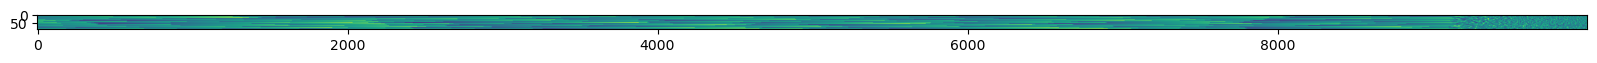

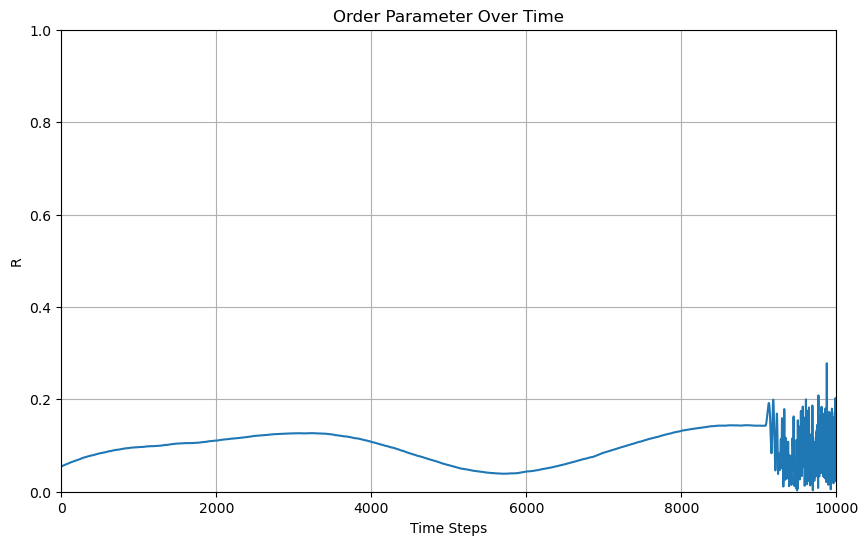

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 2856.42it/s]


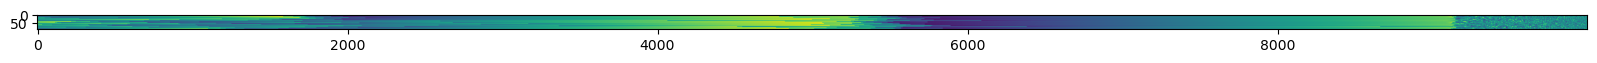

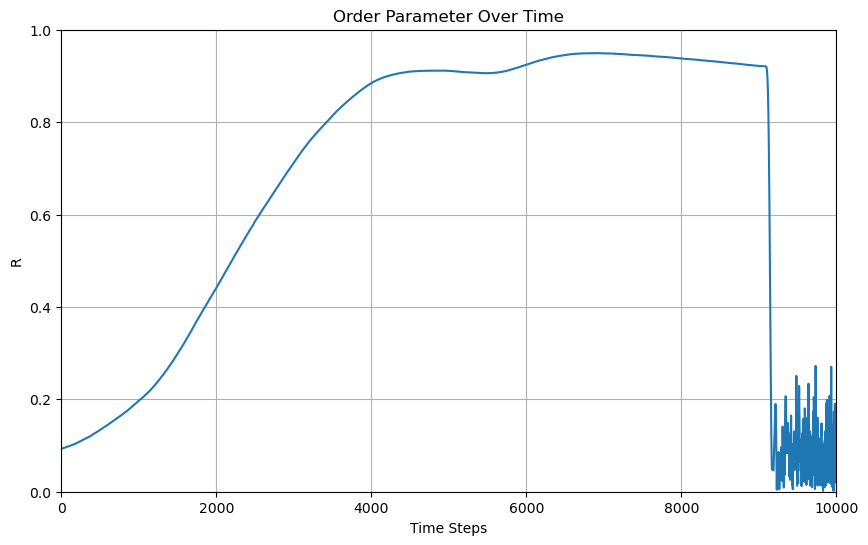

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:04<00:00, 2225.80it/s]


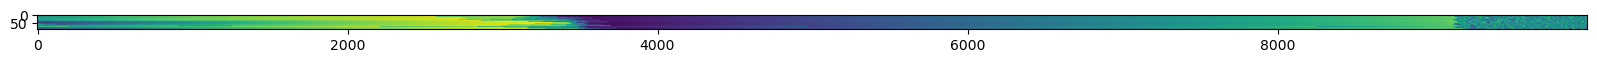

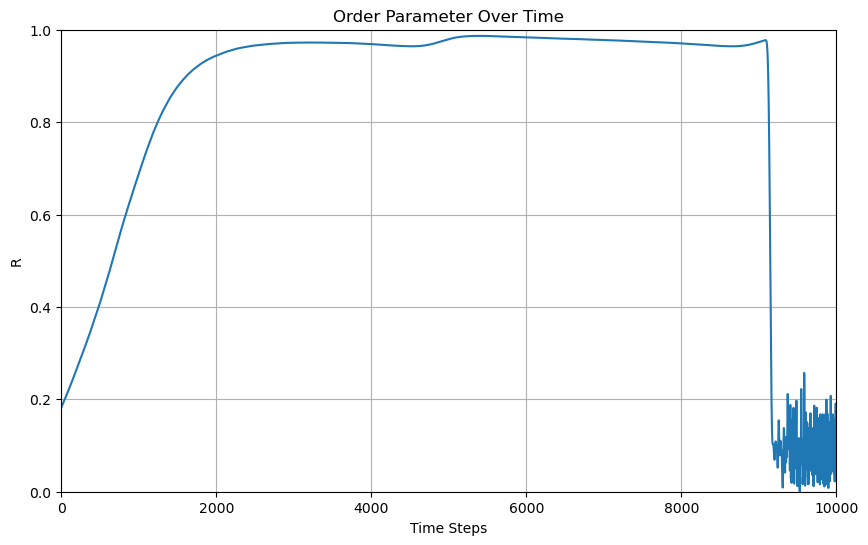

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:05<00:00, 1703.88it/s]


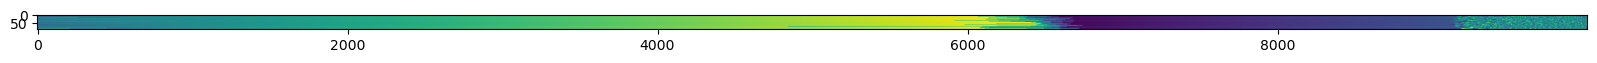

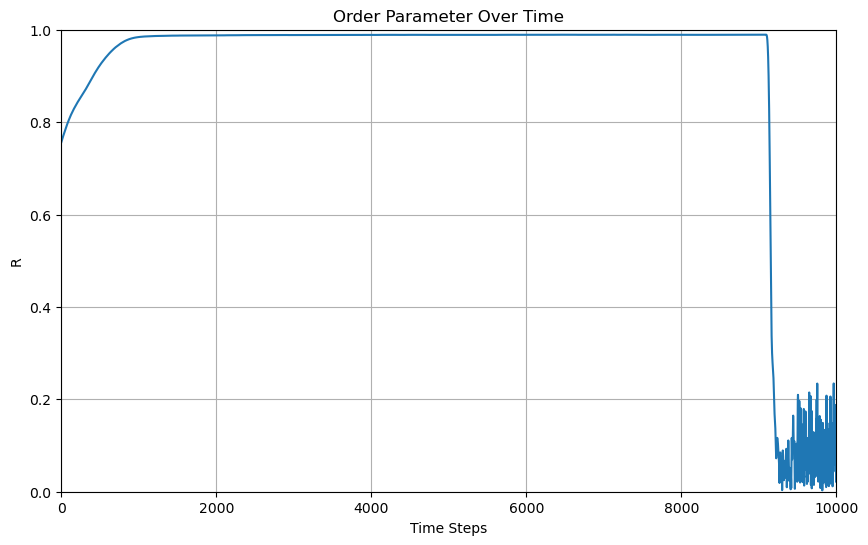

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:08<00:00, 1204.70it/s]


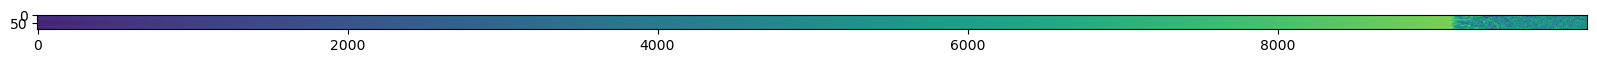

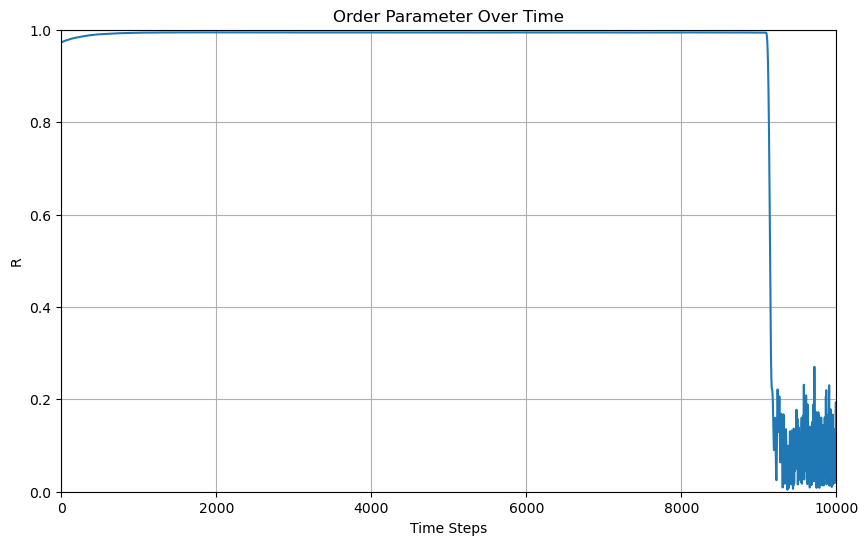

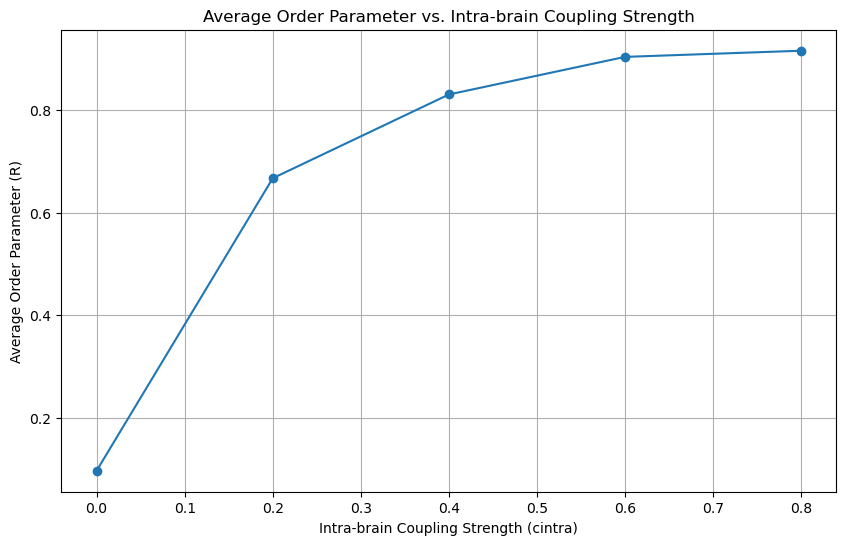

In [57]:
cintra = 0
cintra_values = np.arange(0.0, 1.0, 0.2)
R_avg_values = []  # To collect average R values for each cintra

w_d = np.array(loadmat("distance.mat")['distance'])
pulsations = (np.random.randn(1, n) * freq_std_factor * freq_std + freq_mean) * (2 * pi) / (sfreq)

times = arange(0, n_times, 1. / float(sfreq))

velocity = 1.65 # 6 or 1.65 (Dumas e2012)?


def kuramotos():
        for i in range(n):
            yield ω[i] + 0.1 * (sum(
                A[j, i] * sin(y(j, t - τ[i, j]) - y(i))
                for j in range(n)
            ) + phase_noise * input(i))

for cintra in cintra_values:
    
    # Intra-brain coupling
    w_c = np.array(dti * cintra)

    ω = pulsations.flatten()
    A = w_c
    τ = sfreq * w_d / velocity

    input_data = np.random.normal(size=(len(times), n))
    input_spline = CubicHermiteSpline.from_data(times, input_data)


    DDE = jitcdde_input(f_sym=kuramotos,
                            n=n,
                            input=input_spline,
                            verbose=True)

    DDE.compile_C(simplify=False, do_cse=False, chunk_size=1)
    DDE.set_integration_parameters(rtol=0.0001, atol=0.0000001)
    DDE.constant_past(random.uniform(0, 2 * pi, n), time=0.0)
    DDE.integrate_blindly(max(τ), 1)
    # DDE.t: 9.150162697654958

    output = []
    for time in tqdm(DDE.t + times):
	    output.append([*DDE.integrate(time) % (2*pi)])
    
    phases = np.array(output)


    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(phases))

    R = np.abs(np.mean(np.exp(1j * phases), axis=1))
    R_avg = np.mean(R)  # Average R over time for steady-state estimate
    R_avg_values.append(R_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(R, label='Order Parameter (R)')
    plt.xlabel('Time Steps')
    plt.ylabel('R')
    plt.xlim(0,np.max(phases.shape[0]))
    plt.ylim(0, 1)
    plt.title('Order Parameter Over Time')
    plt.grid(True)
    plt.show()
         

plt.figure(figsize=(10, 6))
plt.plot(cintra_values, R_avg_values, '-o', label='Average Order Parameter (R)')
plt.xlabel('Intra-brain Coupling Strength (cintra)')
plt.ylabel('Average Order Parameter (R)')
plt.title('Average Order Parameter vs. Intra-brain Coupling Strength')
plt.grid(True)
plt.show()
    

# VARYING NOISE PARAMETERS WITH CINTER

In [58]:
dti = loadmat("connectomes.mat")['cuban'] # self-connections (diagonals) are already 0

## NORMALISATION!!!!
# A = A-min(A) / (max(A)-min(A))      OR       A = A/sum(A)         OR(?)  dti/np.mean(dti)

nsfreq = 100.0
freq_mean = 4.0 # theta oscillations 
freq_std_factor = 1

n = 90

1.0


Currently calculating for freq_std: 1.0, phase_noise: 1.0, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 31485.65it/s]


Currently calculating for freq_std: 1.0, phase_noise: 1.0, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:05<00:00, 1846.09it/s]


Currently calculating for freq_std: 1.0, phase_noise: 1.0, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:07<00:00, 1423.34it/s]


Currently calculating for freq_std: 1.0, phase_noise: 1.0, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:08<00:00, 1181.06it/s]


Currently calculating for freq_std: 1.0, phase_noise: 1.0, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:07<00:00, 1336.17it/s]


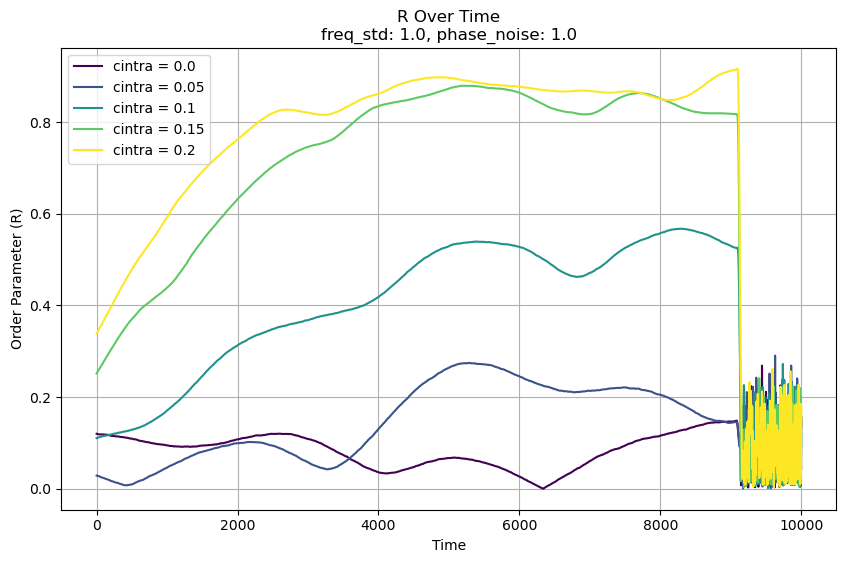

Currently calculating for freq_std: 1.0, phase_noise: 0.5, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 42945.03it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.5, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 3068.74it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.5, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:06<00:00, 1536.85it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.5, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 2824.95it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.5, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 2996.96it/s]


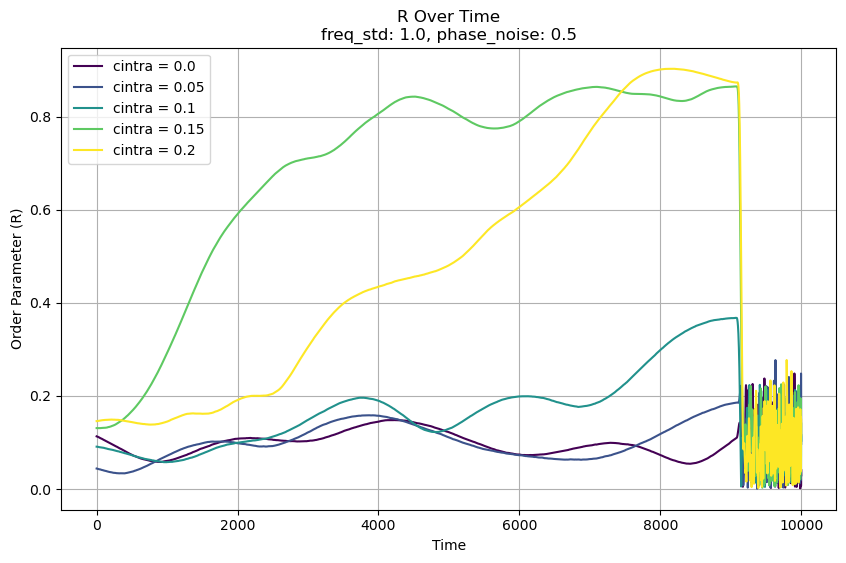

Currently calculating for freq_std: 1.0, phase_noise: 0.0, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 61202.93it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.0, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 20100.77it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.0, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 20557.59it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.0, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 24306.13it/s]


Currently calculating for freq_std: 1.0, phase_noise: 0.0, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 42422.50it/s]


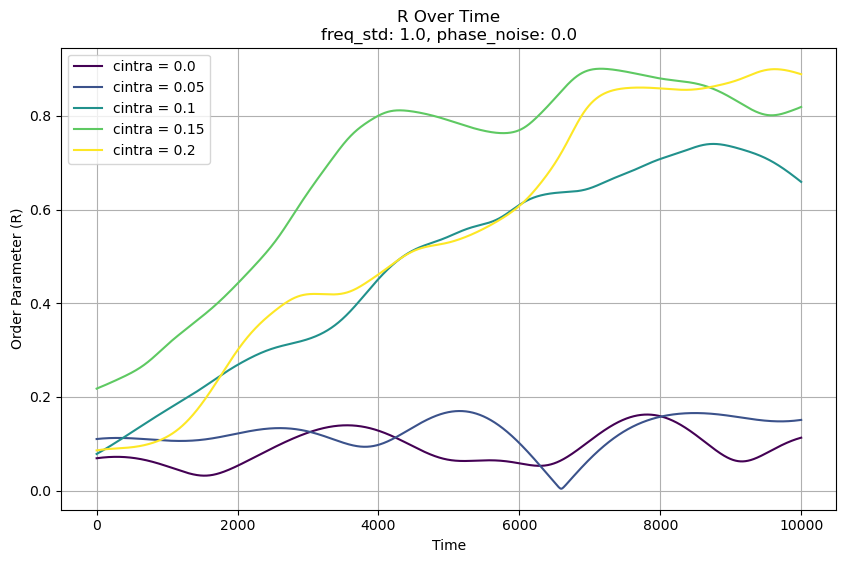

Currently calculating for freq_std: 0.5, phase_noise: 1.0, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 25481.15it/s]


Currently calculating for freq_std: 0.5, phase_noise: 1.0, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:05<00:00, 1773.03it/s]


Currently calculating for freq_std: 0.5, phase_noise: 1.0, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:06<00:00, 1645.04it/s]


Currently calculating for freq_std: 0.5, phase_noise: 1.0, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:05<00:00, 1767.90it/s]


Currently calculating for freq_std: 0.5, phase_noise: 1.0, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:05<00:00, 1934.80it/s]


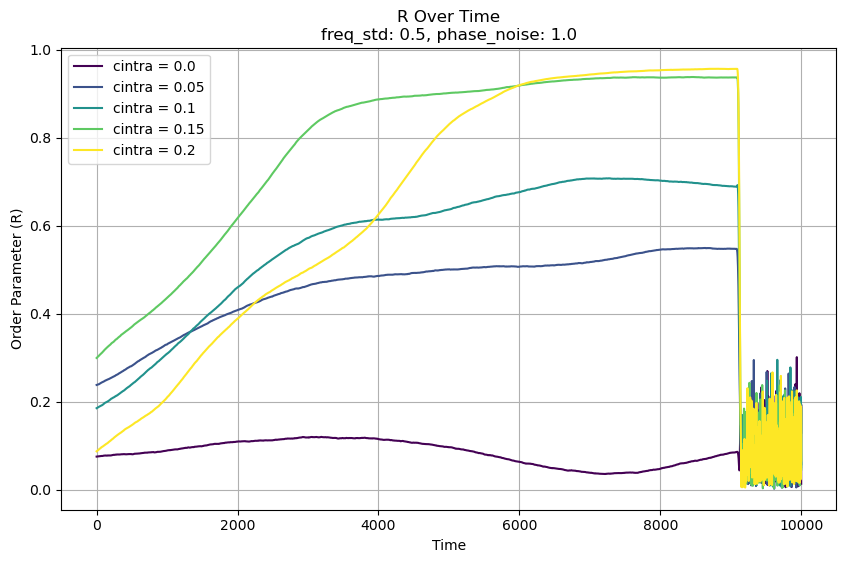

Currently calculating for freq_std: 0.5, phase_noise: 0.5, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 60659.72it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.5, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:07<00:00, 1391.79it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.5, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 2853.21it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.5, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:04<00:00, 2250.75it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.5, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 2988.01it/s]


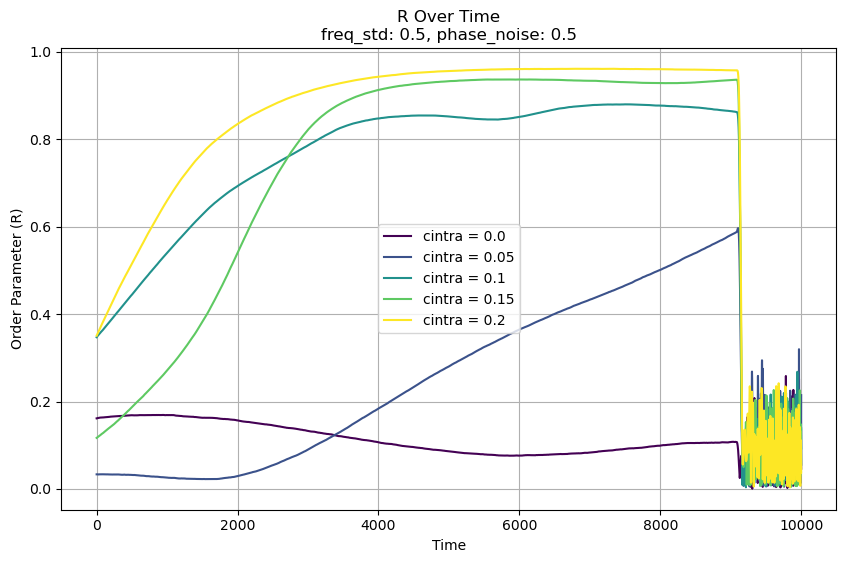

Currently calculating for freq_std: 0.5, phase_noise: 0.0, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 68106.93it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.0, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 17471.34it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.0, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 29356.01it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.0, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 10657.50it/s]


Currently calculating for freq_std: 0.5, phase_noise: 0.0, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 27439.07it/s]


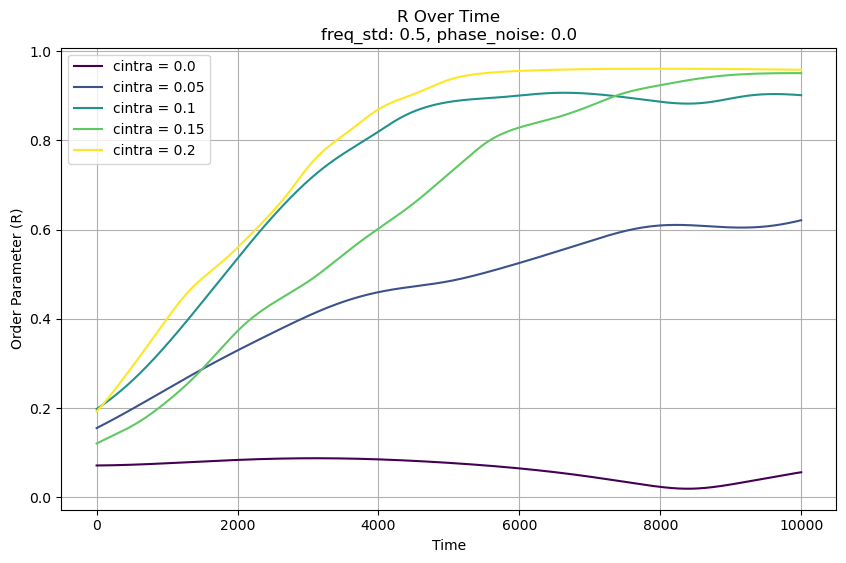

Currently calculating for freq_std: 0.0, phase_noise: 1.0, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 10592.13it/s]


Currently calculating for freq_std: 0.0, phase_noise: 1.0, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:06<00:00, 1481.61it/s]


Currently calculating for freq_std: 0.0, phase_noise: 1.0, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:05<00:00, 1679.35it/s]


Currently calculating for freq_std: 0.0, phase_noise: 1.0, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:10<00:00, 997.43it/s]


Currently calculating for freq_std: 0.0, phase_noise: 1.0, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:06<00:00, 1512.15it/s]


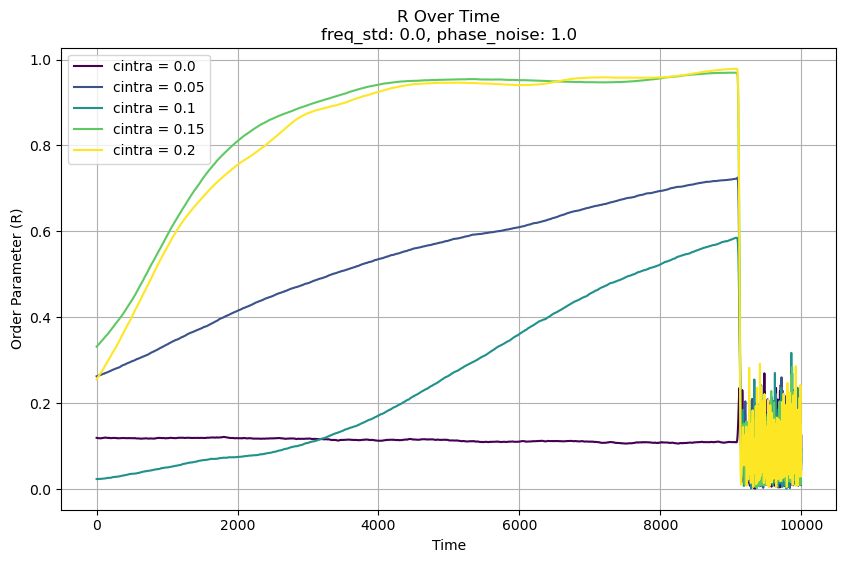

Currently calculating for freq_std: 0.0, phase_noise: 0.5, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 39732.03it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.5, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 3131.04it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.5, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 2737.69it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.5, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:06<00:00, 1571.08it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.5, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:02<00:00, 3765.43it/s]


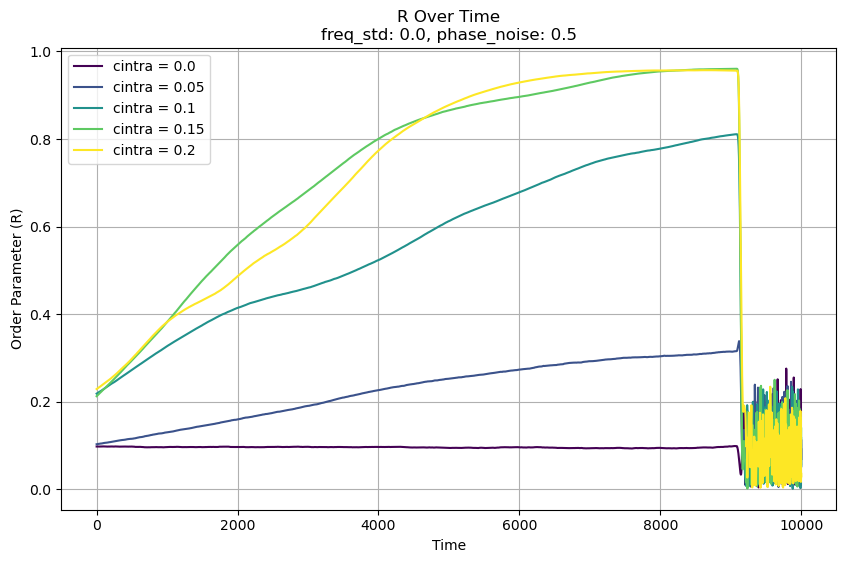

Currently calculating for freq_std: 0.0, phase_noise: 0.0, cintra: 0.0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 62521.95it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.0, cintra: 0.1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 37938.86it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.0, cintra: 0.15...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 39939.44it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.0, cintra: 0.2...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 37452.32it/s]


Currently calculating for freq_std: 0.0, phase_noise: 0.0, cintra: 0.05...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 47749.58it/s]


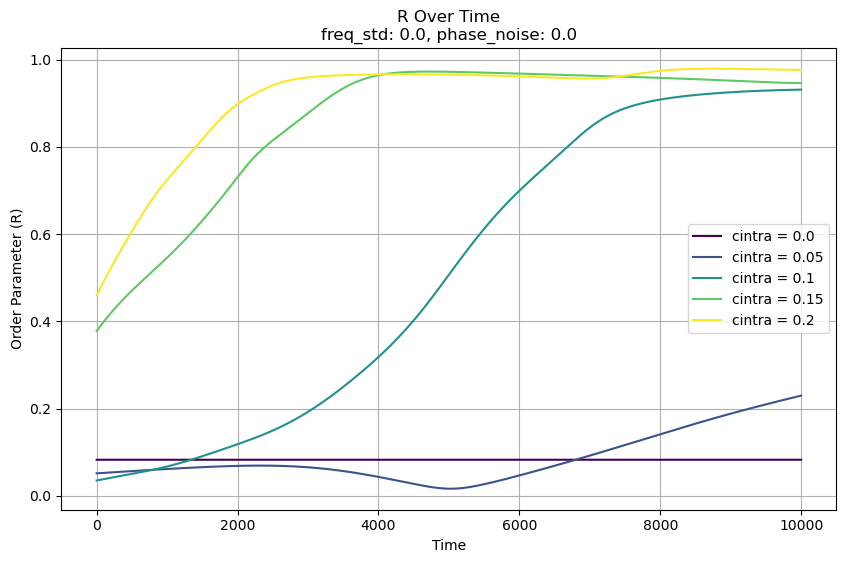

In [66]:
cintra_values = [0.0, 0.05, 0.1, 0.15, 0.2]
value_range = [1.0, 0.5, 0.0]

w_d = np.array(loadmat("distance.mat")['distance'])
times = arange(0, n_times, 1. / float(sfreq))
velocity = 1.65 # (Dumas e2012) or 6?

results = {}

def kuramotos():
        for i in range(n):
            yield ω[i] + 0.1 * (sum(
                A[j, i] * sin(y(j, t - τ[i, j]) - y(i))
                for j in range(n)
            ) + phase_noise * input(i))

for freq_std in value_range:

    pulsations = (np.random.randn(1, n) * freq_std_factor * freq_std + freq_mean) * (2 * pi) / (sfreq)
    ω = pulsations.flatten()

    for phase_noise in value_range:

        condition = (freq_std, phase_noise)
        results[condition] = {}

        cintra_R_values = {}

        for cintra in cintra_values:
            
            print(f"Currently calculating for freq_std: {freq_std}, phase_noise: {phase_noise}, cintra: {cintra}...")

            # Intra-brain coupling
            w_c = np.array(dti * cintra)

            A = w_c
            τ = sfreq * w_d / velocity

            input_data = np.random.normal(size=(len(times), n))
            input_spline = CubicHermiteSpline.from_data(times, input_data)


            DDE = jitcdde_input(f_sym=kuramotos,
                                    n=n,
                                    input=input_spline,
                                    verbose=True)

            DDE.compile_C(simplify=False, do_cse=False, chunk_size=1)
            DDE.set_integration_parameters(rtol=0.0001, atol=0.0000001)
            DDE.constant_past(random.uniform(0, 2 * pi, n), time=0.0)
            DDE.integrate_blindly(max(τ), 1)
            # DDE.t: 9.150162697654958

            output = []
            for time in tqdm(DDE.t + times):
                output.append([*DDE.integrate(time) % (2*pi)])
            
            phases = np.array(output)

            # Calculate ORDER PARAMETER
            R = np.abs(np.mean(np.exp(1j * phases), axis=1)) # len(R) = 10,000
            # R_avg = np.mean(R)  # Average R over time for steady-state estimate
            

            cintra_R_values[cintra] = R

        plt.figure(figsize=(10, 6))
        color_map = plt.get_cmap('viridis')
        colors = color_map(np.linspace(0, 1, len(cintra_values)))

        for i, cintra in enumerate(sorted(cintra_R_values.keys())):
            plt.plot(cintra_R_values[cintra], label=f'cintra = {cintra}', color=colors[i])

        plt.xlabel('Time')
        plt.ylabel('Order Parameter (R)')
        plt.title(f'R Over Time\nfreq_std: {freq_std}, phase_noise: {phase_noise}')
        plt.legend()
        plt.grid(True)
        plt.show()

        results[(freq_std, phase_noise)] = cintra_R_values
    

In [79]:
n_times

100